In [1]:
import encode_to_contact_utils as util
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
CHROMOSOME = "chr10"
START_INIT = 13600000
RESOLUTION = 8000
PATCH_SIZE = 120
PATCH_NUM = 20
MODE = "mean"
DIAG_STOP = 60
MAIN_FOLDER = ".local/experiment_results"

In [3]:
start = START_INIT // RESOLUTION
stop = START_INIT + RESOLUTION * PATCH_SIZE
stop = stop // RESOLUTION

In [4]:
BATCH = [0, 1, 3, 6, 8, 10, 12, 13]

In [5]:
GO_N = 0

In [6]:
START = START_INIT + GO_N * RESOLUTION * PATCH_SIZE
STOP = START_INIT + (GO_N+1) * RESOLUTION * PATCH_SIZE

In [7]:
f'{CHROMOSOME}:{START}-{STOP}'

'chr10:13600000-14560000'

In [8]:
import pandas as pd

def zscore(data):
    return (data - data.mean(axis=0).reshape(1,-1)) / data.std(axis=0).reshape(1,-1)

def batch_data(init, batch):
    map_h1 = np.empty((len(batch), PATCH_SIZE, PATCH_SIZE))
    map_hff = np.empty((len(batch), PATCH_SIZE, PATCH_SIZE))
    encode_h1 = np.empty((len(batch), PATCH_SIZE, 4))
    encode_hff = np.empty((len(batch), PATCH_SIZE, 4))

    sequence_h1 = pd.read_csv(".data/ForGrant/H1ctcfBinned.txt", sep="\t", index_col=0).iloc[:,1:]
    sequence_hff = pd.read_csv(".data/ForGrant/HFFctcfBinned.txt", sep="\t", index_col=0).iloc[:,1:]

    for i in range(len(batch)):
        start = init + PATCH_SIZE * RESOLUTION * batch[i]
        stop = init + PATCH_SIZE * RESOLUTION * (batch[i] + 1)
        map_h1[i,:,:], map_hff[i,:,:], encode_h1[i,:,:4], encode_hff[i,:,:4], signal_names = util.read_data(
                                        ".data/ForGrant/chr10_8k_H1.npy",
                                        ".data/ForGrant/chr10_8k_HFF.npy",
                                        ".data/ForGrant/bestTracksBinned.txt",
                                        "../loopExtraction/data/ctcf/MA0139.1.neg.score.sorted.bedgraph",
                                        "../loopExtraction/data/ctcf/MA0139.1.pos.score.sorted.bedgraph",
                                        MODE,
                                        CHROMOSOME,
                                        start,
                                        stop,
                                        RESOLUTION)
        start = start//RESOLUTION
        stop = stop//RESOLUTION
        #encode_h1[i,:,2:] = zscore(sequence_h1[start:stop].to_numpy())
        #encode_hff[i,:,2:] = zscore(sequence_hff[start:stop].to_numpy())

    exclude_dnase = [0, 2, 3]#, 4, 5]
    encode_h1 = encode_h1[:, :, exclude_dnase]
    encode_hff = encode_hff[:, :, exclude_dnase]
        
    return map_h1, map_hff, encode_h1, encode_hff, np.concatenate([[signal_names[0]], ["CTCF_neg", "CTCF_pos"]])#np.concatenate([signal_names[:2], sequence_h1.columns.to_numpy()])#[exclude_dnase]


In [9]:
map_h1_batch, map_hff_batch, encode_h1_batch, encode_hff_batch, signal_names = batch_data(START_INIT, BATCH)

In [10]:
map_h1_batch.shape, encode_hff_batch.shape

((8, 120, 120), (8, 120, 3))

In [11]:
signal_names

array(['CTCF', 'CTCF_neg', 'CTCF_pos'], dtype='<U8')

In [12]:
color_dict = util.assign_unique_colors(signal_names)

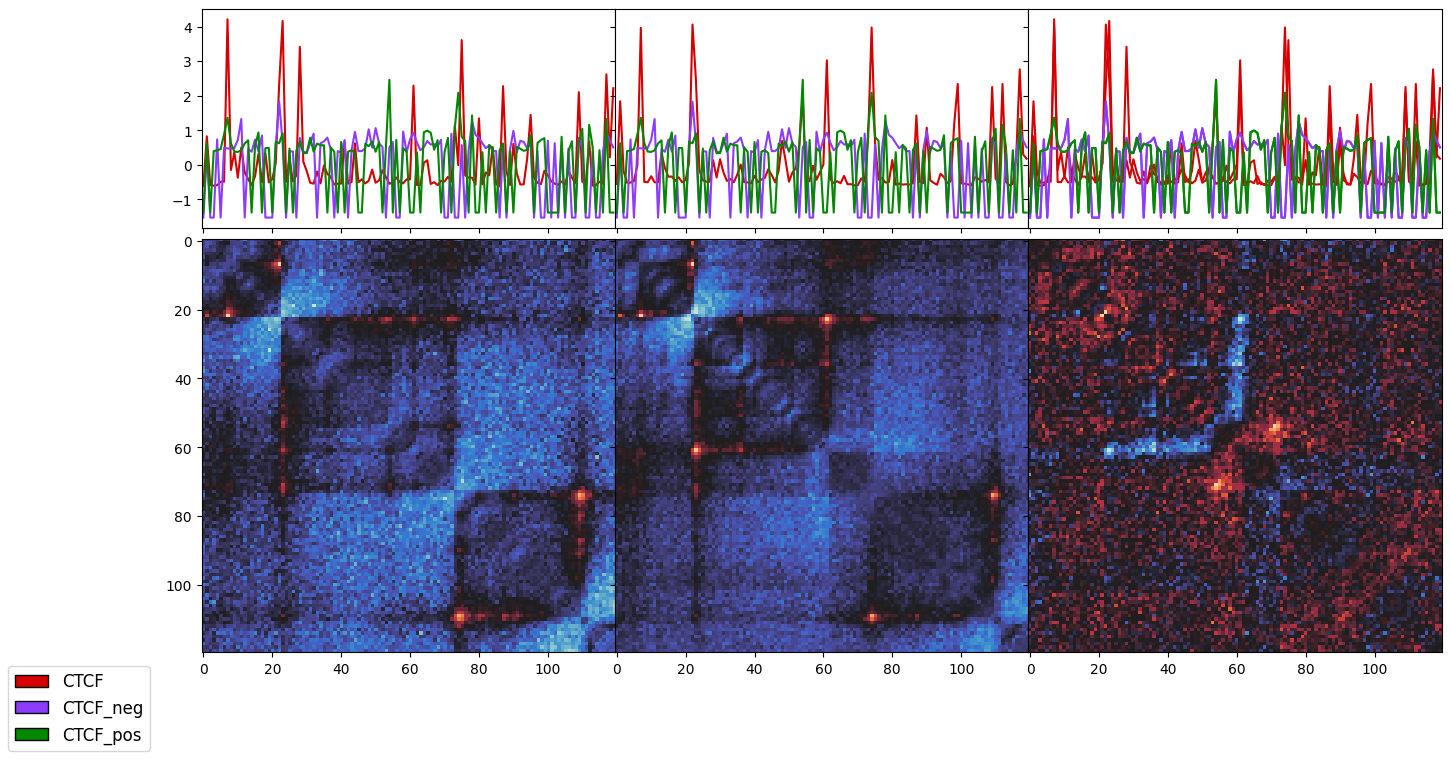

In [13]:
util.plot_map_diff(map_h1_batch[0], map_hff_batch[0], encode_h1_batch[0], encode_hff_batch[0], signal_names, signal_names, color_dict)

In [14]:
map_h1 = torch.tensor(map_h1_batch, dtype=torch.float32)
map_hff = torch.tensor(map_hff_batch, dtype=torch.float32)
encode_h1 = torch.tensor(encode_h1_batch, dtype=torch.float32)
encode_hff = torch.tensor(encode_hff_batch, dtype=torch.float32)

In [15]:
map_train = map_hff #torch.vstack([map_hff, map_h1])
map_val = map_h1 #torch.vstack([map_h1, map_hff])
encode_train = encode_hff #torch.vstack([encode_hff, encode_h1])
encode_val = encode_h1 #torch.vstack([encode_h1, encode_hff])

In [16]:
map_train.shape, encode_train.shape

(torch.Size([8, 120, 120]), torch.Size([8, 120, 3]))

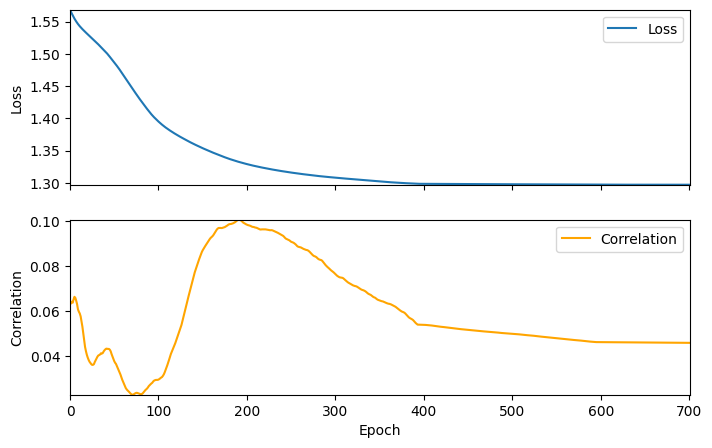

  7/100: correlation = 0.046, loss = 1.297


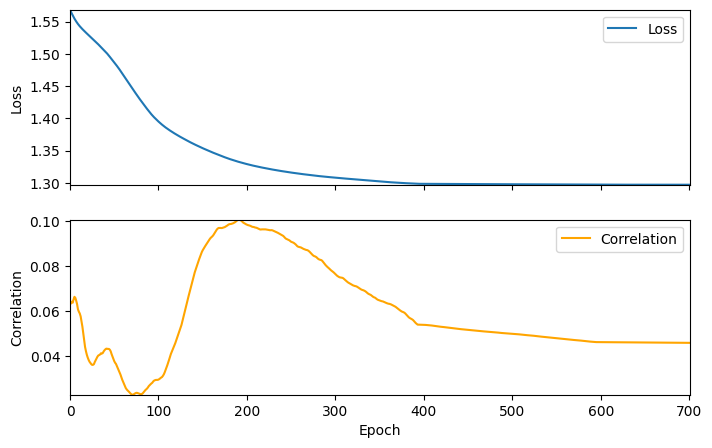

In [17]:
dev = torch.device('cuda')
best_loss_model, best_corr_model, arr_loss, arr_corr = util.run_training(map_train[[0]],
                                                                         map_val[[0]],
                                                                         encode_train[[0]],
                                                                         encode_val[[0]],
                                                                         dev,
                                                                         learning_rate=0.001,
                                                                         patience=200,
                                                                         diag_start=3,
                                                                         diag_stop=DIAG_STOP,
                                                                         num_epoch=10000)

In [18]:
model_selected = best_loss_model

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(12 * 3,14),
                        sharex='col',
                        sharey='row',
                        gridspec_kw={'wspace':0,
                                    'hspace':0,
                                    'height_ratios':[10, 50, 10],
                                    'width_ratios':[50, 10]*3})

batch_select_i = 0
util.plot_results_comp_train_val(model_selected, map_train[batch_select_i],
                                                  map_val[batch_select_i],
                                                  encode_train[batch_select_i],
                                                  encode_val[batch_select_i],
                                                  DIAG_STOP, 
                                 axes=axes)

TypeError: plot_results_comp_train_val() got multiple values for argument 'cmap_train'

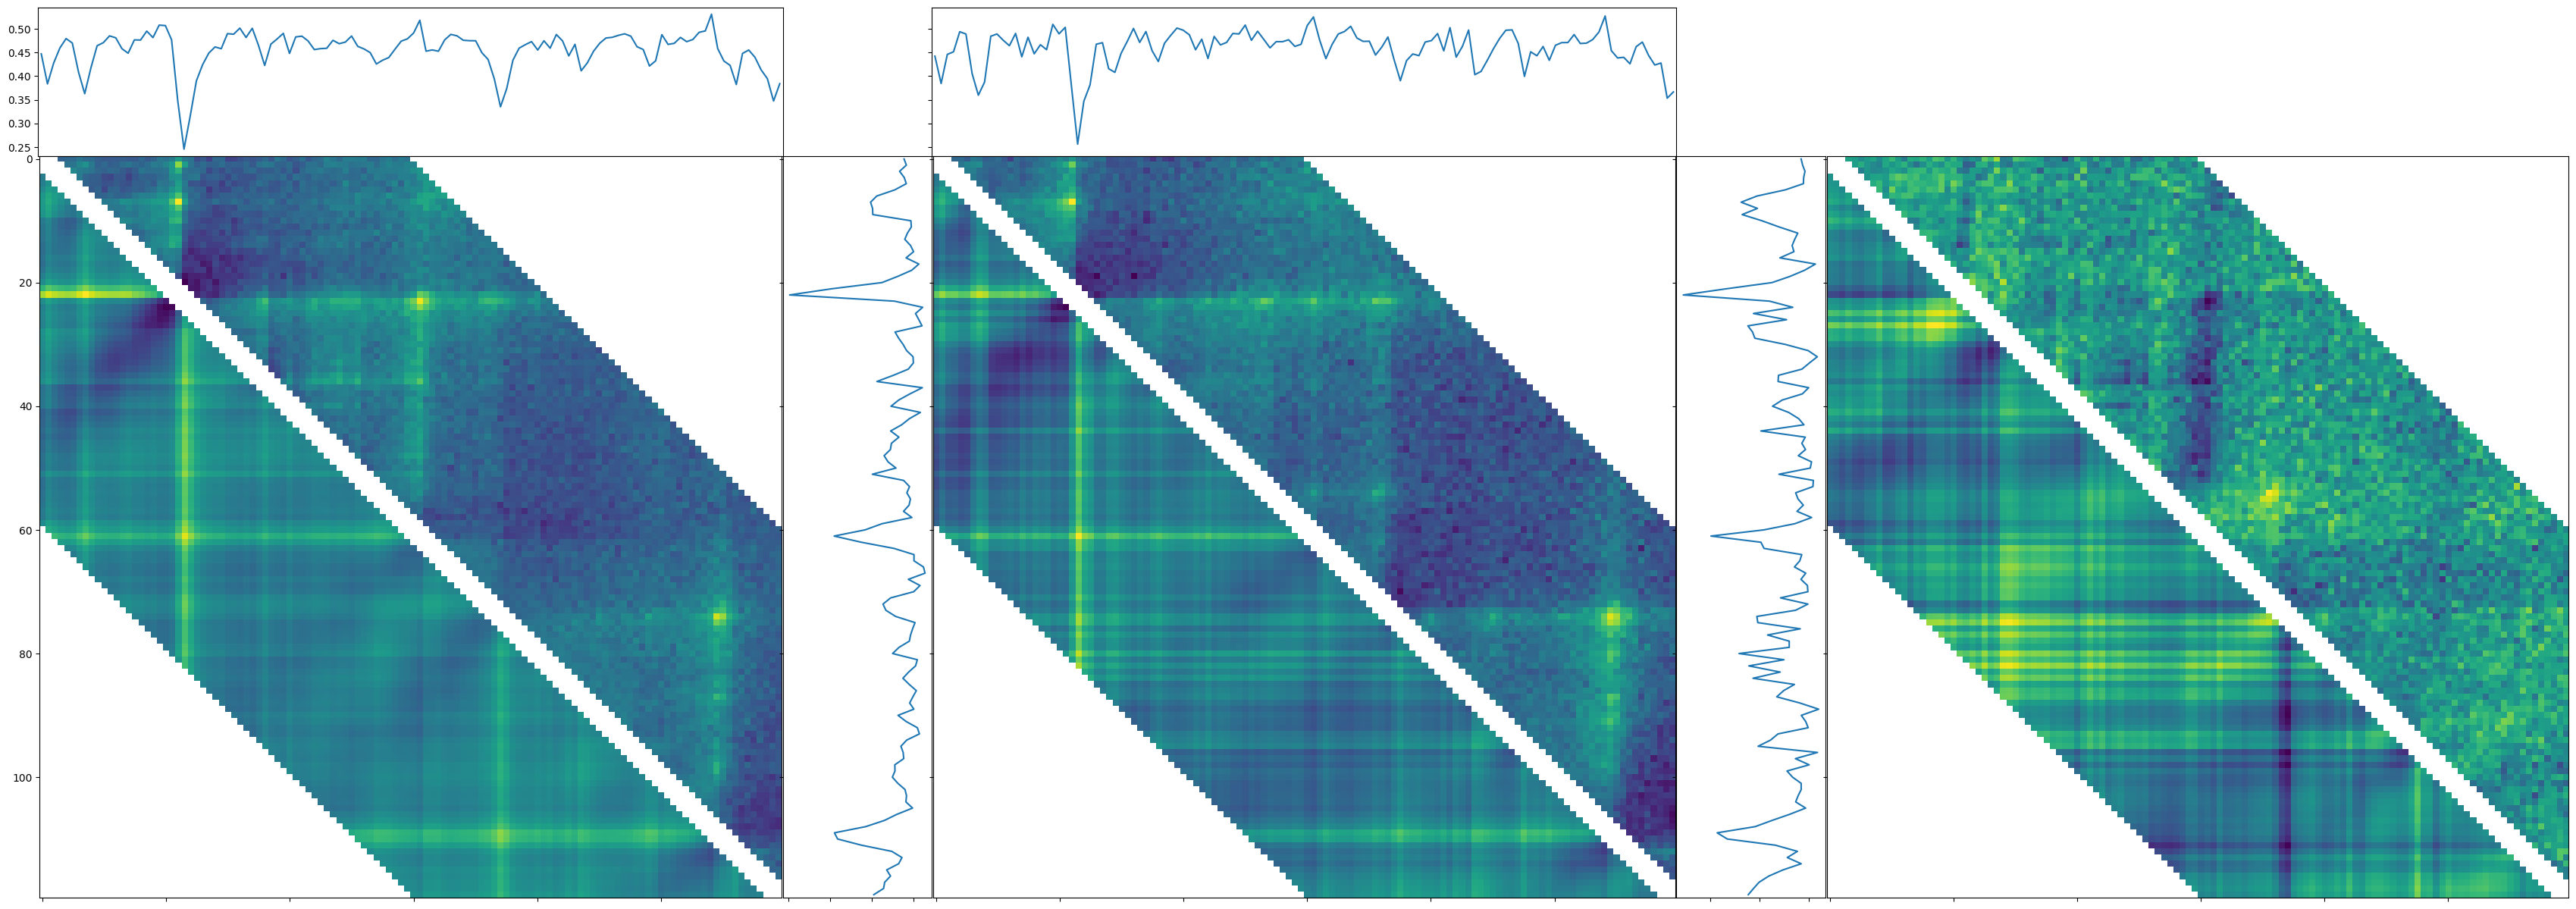

In [20]:
fig

In [21]:
signal_names

array(['CTCF', 'CTCF_neg', 'CTCF_pos'], dtype='<U8')

In [22]:
def plot_results_comp_params_sig(model, encode_train, encode_val, axes=None):
    n = encode_train.shape[1]
    if axes is None:
        _, axes = plt.subplots(nrows=n, ncols=2, figsize=(15,6),
                               sharex='col',
                               sharey='row',
                               gridspec_kw={'wspace':0,
                                           'hspace':0})
    _, p_l_train, p_r_train = util.return_model_result(model, encode_train[None])
    _, p_l_val, p_r_val = util.return_model_result(model, encode_val[None])
    for i in range(n-2):
        axes[i, 0].plot(encode_train[:,i])
        axes[i, 0].plot(encode_val[:,i])
        axes[i, 1].plot(encode_train[:,i])
        axes[i, 1].plot(encode_val[:,i])
    axes[n-2, 0].plot(encode_train[:,n-1])
    axes[n-2, 1].plot(encode_train[:,n-2])
    axes[n-1, 0].plot(p_l_train)
    axes[n-1, 0].plot(p_l_val)
    axes[n-1, 1].plot(p_r_train)
    axes[n-1, 1].plot(p_r_val)


In [23]:
n = encode_train.shape[2]
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(15,6),
                        sharex='col',
                        sharey='row',
                        gridspec_kw={'wspace':0,
                                    'hspace':0})
plot_results_comp_params_sig(model_selected, encode_train[0], encode_val[0], axes=axes)

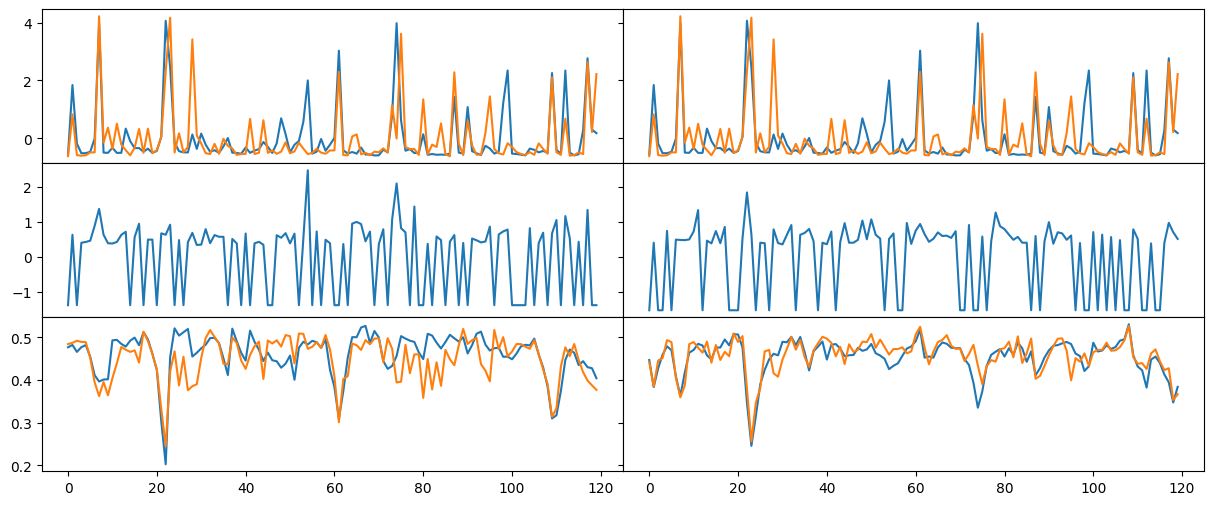

In [24]:
fig

In [25]:
#torch.save(best_corr_model.state_dict(), ".local/best_corr_hfftoh1.pt")
#torch.save(best_loss_model.state_dict(), ".local/best_loss_hfftoh1.pt")

In [26]:
pred_train, p_l_train, p_r_train = util.return_model_result(model_selected, encode_train[[0]])
pred_val, p_l_val, p_r_val = util.return_model_result(model_selected, encode_val[[0]])

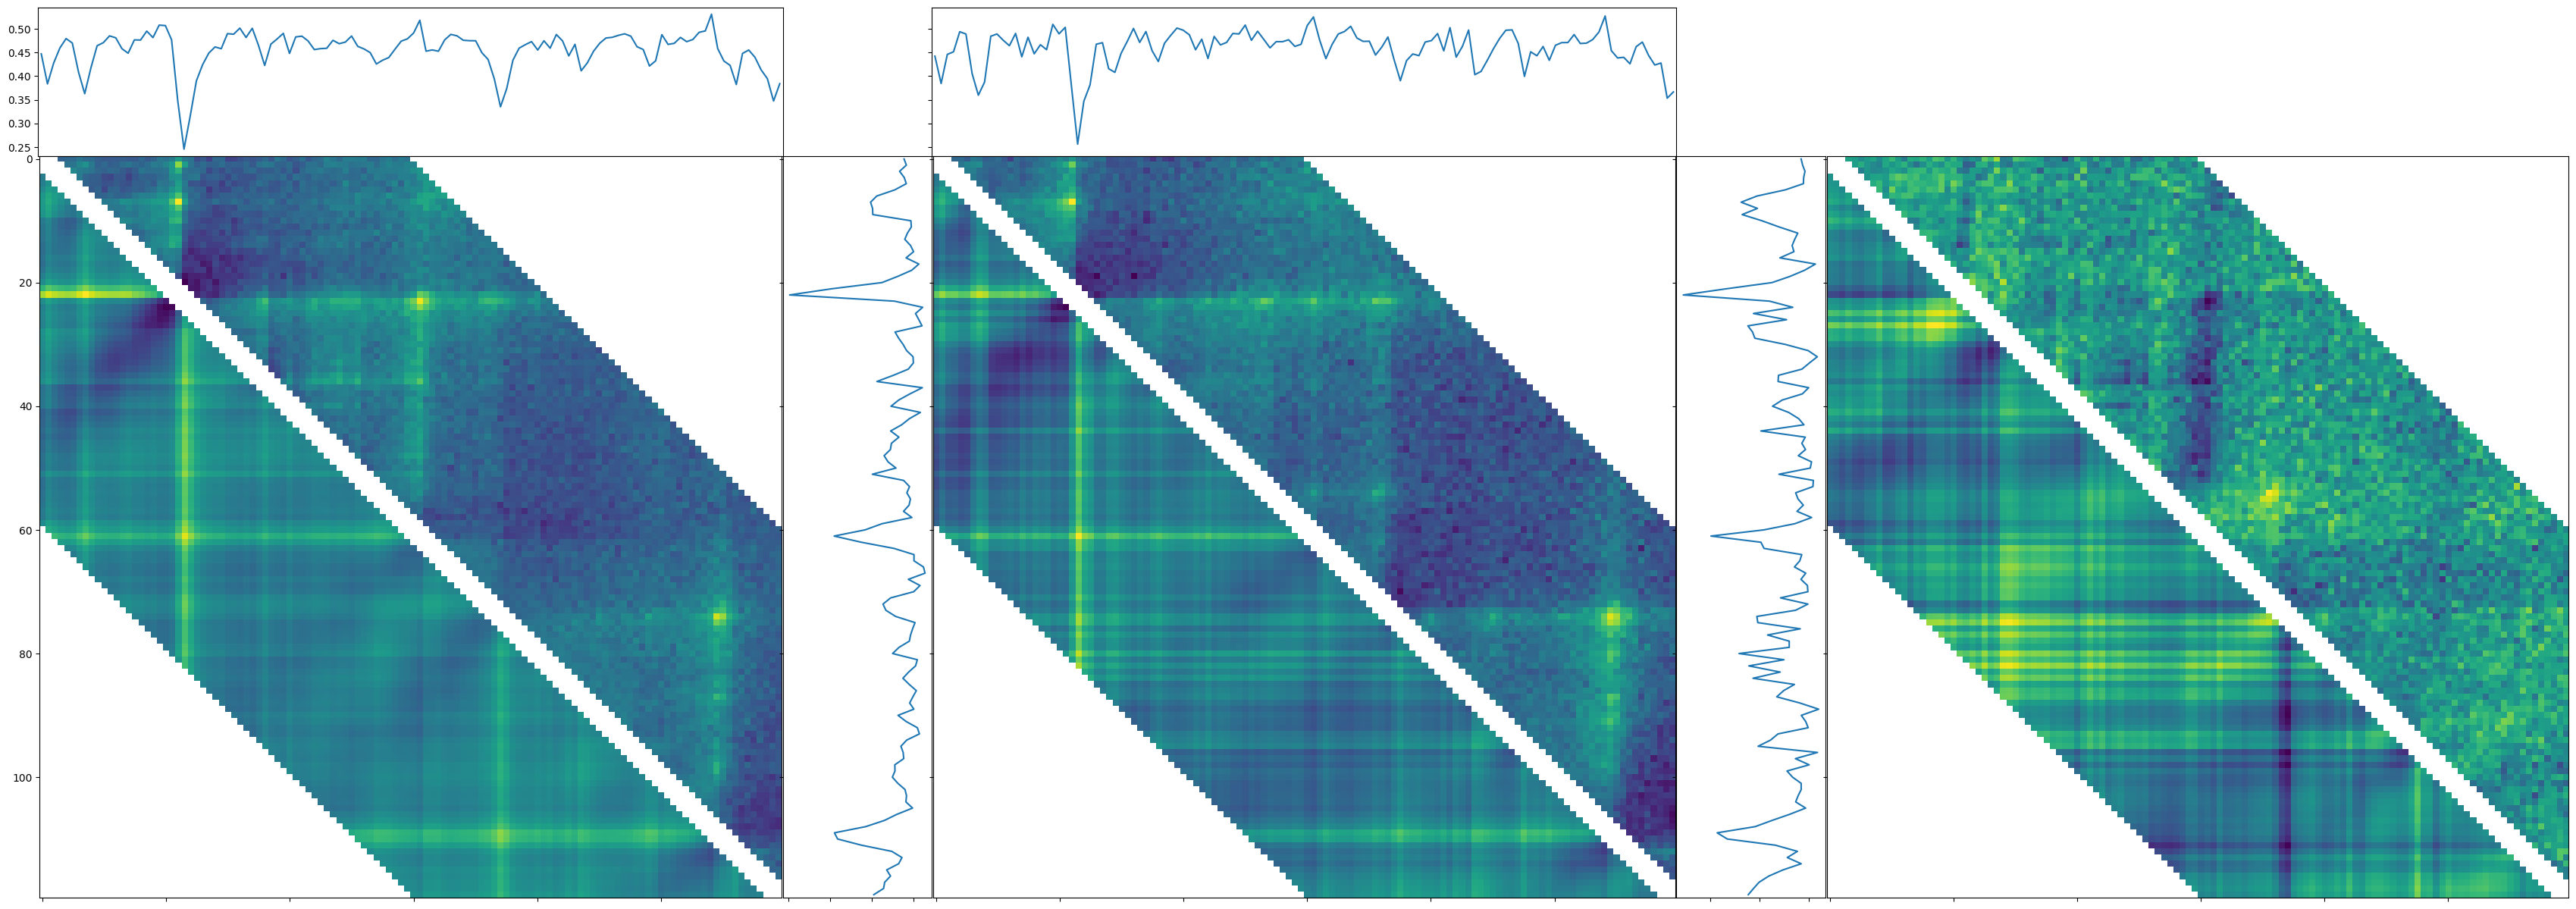

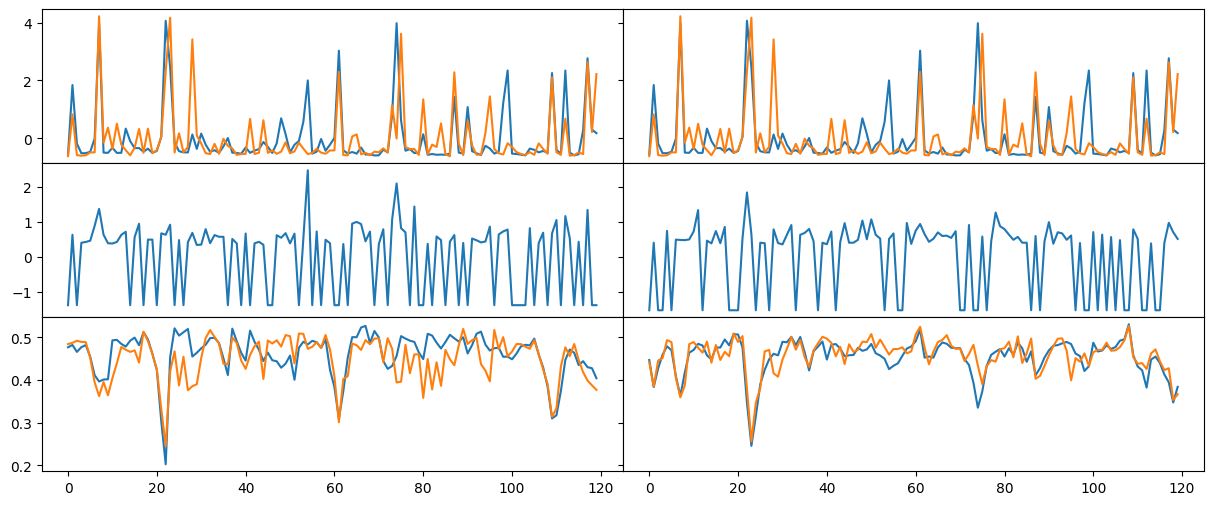

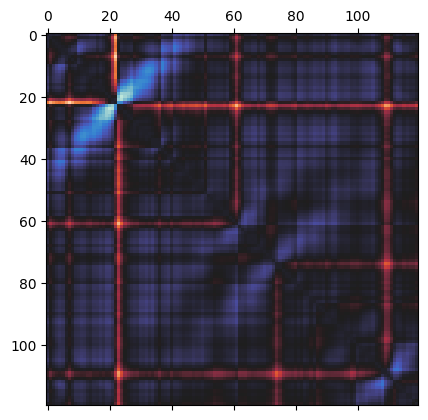

In [27]:
plt.matshow(pred_train, cmap="icefire")
plt.show()

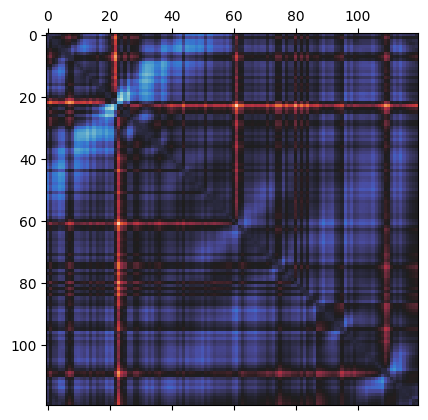

In [28]:
plt.matshow(pred_val, cmap="icefire")
plt.show()

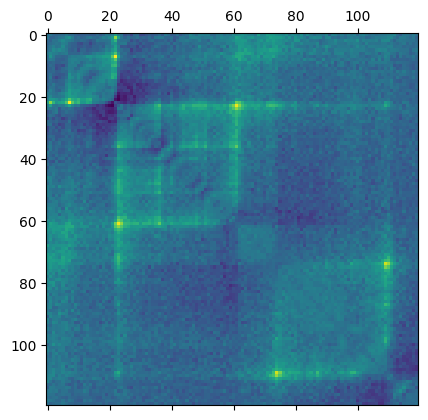

In [29]:
plt.matshow(map_train[0])
plt.show()

In [30]:
#np.savez(".local/best_corr_hfftoh1.npz", pred_train=pred_train,
#                                         pred_val=pred_val,
#                                         p_l_train=p_l_train,
#                                         p_l_val=p_l_val,
#                                         p_r_train=p_r_train,
#                                         p_r_val=p_r_val,
#                                         map_train=map_train[0],
#                                         map_val=map_val[0]
#        )